# Reconstructing GATE Data

The following example provides a complete example of a PET reconstruction from data generated from the GATE Monte Carlo program, including the computation of a normalization factor from a normalization scan. If you want to gain access to these files, please email me at `lukepolson@outlook.com`

In [1]:
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta, PETTOFMeta
from pytomography.projectors import PETLMSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate
import os
from pytomography.transforms import GaussianFilter
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.is_available()

In [2]:
# Change this
path = '/disk1/pet_mri_scan/'

PET listmode reconstruction via MLEM can be written as

$$\hat{f}^{n+1} = \left[\frac{1}{\tilde{H}^T \eta \mu 1} H^T \left(\frac{1}{H\hat{f}^{n}+s+r}\right)\right] \hat{f}^{n}$$

* The system matrix $H$ projects an object to all detected LORs via ray-tracing. 
* The "complete" system matrix $\tilde{H}$ projects an object to all possible valid LORs of the scanner via ray-tracing. 
* The attenuation correction factor $\mu$ depends on an attenuation map obtained via a CT/MRI scan. 
* The normalization $\eta$ is slightly more complicated: depending on the geomtrical arrangement of crystals as well as the efficiency of all crystals.

In this tutorial, we'll look at data from a simulation that was "attenuation-free" so $\mu=1$ everywhere. We still, however, need $\eta$ if we are to reconstruct PET data from this scanner. We'll start by obtaining $\eta$ via a "simulated normalization scan"; this was obtained by simulating acquisition of a thin cylindrical shell with large radius. Functionality exists in PyTomography for obtaining $\eta$ from such a scan.

# Normalization Computation

**The cell below only needs to be ran once**, and may take a long time, as it requires opening and parsing through all the ROOT files corresponding to the normalization scan. Once it is ran, the normalization $\eta$ will be saved to a file. This particular calibration scan was done using a thin cylindrical shell. We can compute $\eta$ using a particular function in the gate functionality of PyTomography. Then we save it as a `numpy` file for easy access in the next part. For this we need

* `mean_interaction_depth`: The mean interaction depth of photons in the crystals in mm
* `cylinder_radius`: The radius of the thin cylindrical shell used for calibration
* `macro_path`: The path to the macro used in GATE to generate the scanner geometry

In [ ]:
normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]

mean_interaction_depth = 9 # mm
cylinder_radius = 320 # mm (radius of calibration cylindrical shell)
macro_path = os.path.join(path, 'mMR_Geometry.mac')

eta = gate.get_eta_cylinder_calibration(
    normalization_paths,
    macro_path,
    cylinder_radius=cylinder_radius,
    same_source_pos=True, #used to ignore random events in simulation
    mean_interaction_depth=mean_interaction_depth)

np.save(os.path.join(path, 'norm_factor_test.npy'), eta)

Once the above has ran once, we can open the weights as follows:

In [3]:
weights_sensitivity = torch.tensor(np.load(os.path.join(path, 'norm_factor_test.npy')))

# Phantom Reconstruction

**The following cell only needs to be ran once**. The purpose is to convert all the acquired GATE data in ROOT files to a numpy array for easy access. It may take awhile to run. It saves all the detector IDs corresponding to every coincidence event in the scan. It also bins the time of flight.

In [ ]:
# Determine TOF bin edges for binning 
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
scanner_diameter = 2 * 348
num_tof_bins = 125
TOF_bin_edges = np.linspace(-1,1,num_tof_bins+1)*scanner_diameter

# Get detector IDs from GATE file
paths = [os.path.join(path, f'gate_simulation/no_atten/f{i}.root') for i in range(1, 19)]
macro_path = os.path.join(path, 'mMR_Geometry.mac')
detector_ids = gate.get_detector_ids(
    paths,
    macro_path,
    same_source_pos=True, # don't include randoms, can set to false if you want randoms
    TOF=True,
    TOF_bin_edges = TOF_bin_edges)
np.save(os.path.join(path, 'detector_ids.npy'), detector_ids)

Once the cell above has been run, data can be loaded much faster

In [4]:
detector_ids = torch.tensor(np.load(os.path.join(path, 'detector_ids.npy')))

The scanner lookup table is used to get detector coordinates based on the detector IDs. It cam be loaded using the `get_scanner_LUT` function.

In [5]:
scanner_LUT = gate.get_scanner_LUT(
    path = os.path.join(path, 'mMR_Geometry.mac'),
    mean_interaction_depth=9
)

Now it's time to specify the reconstruction parameters. Firstly we create the object space:

In [6]:
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)

Now lets remove all events that are out of bounds of the reconstruction region (important for finite FOV)

In [7]:
detector_ids = gate.remove_events_out_of_bounds(detector_ids, scanner_LUT, object_meta)

Now we create the time of flight metadata based on how we want to arrange the time of flight bins.

In [8]:
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
scanner_diameter = 2 * 348
num_tof_bins = 125
tof_bin_edges = np.linspace(-1,1,num_tof_bins+1)*scanner_diameter
tof_bin_width = tof_bin_edges[1] - tof_bin_edges[0]
tof_meta = PETTOFMeta(num_tof_bins, tof_bin_width , fwhm_tof_resolution, n_sigmas=3)

Now we'll create the projection metadata. We'll specify that weights used for computing the sensitivity image $\tilde{H}^T 1$ are loaded from path (in this case, from the `eta.npy` image). Since no attenuation is used in this simulation, `eta`

In [9]:
proj_meta = PETLMProjMeta(
    detector_ids,
    scanner_LUT,
    tof_meta=tof_meta,
    weights_sensitivity=weights_sensitivity
    )

From the projection metadata we can create the system matrix, which maps from object space to projection space. For listmode PET, projection space corresponds to 1D vectors with number of entries equal to the number of detected events.

In [10]:
psf_transform = GaussianFilter(4)
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    N_splits=8,
)

We'll reconstruct the data using OSEM. In this case, all the "data" is stored in `proj_meta`, since it gives the detector IDs of every detected event. When reconstructing listmode data, its important to pass `torch.tensor([1.])` as the projections argument.

In [13]:
recon_algorithm = OSEM(
    projections=torch.tensor([1.]),
    system_matrix=system_matrix,
)

Now we reconstruct for 2 iterations with 28 subsets

In [14]:
recon = recon_algorithm(n_iters=2, n_subsets=28)

And plot some slices of the reconstruction:

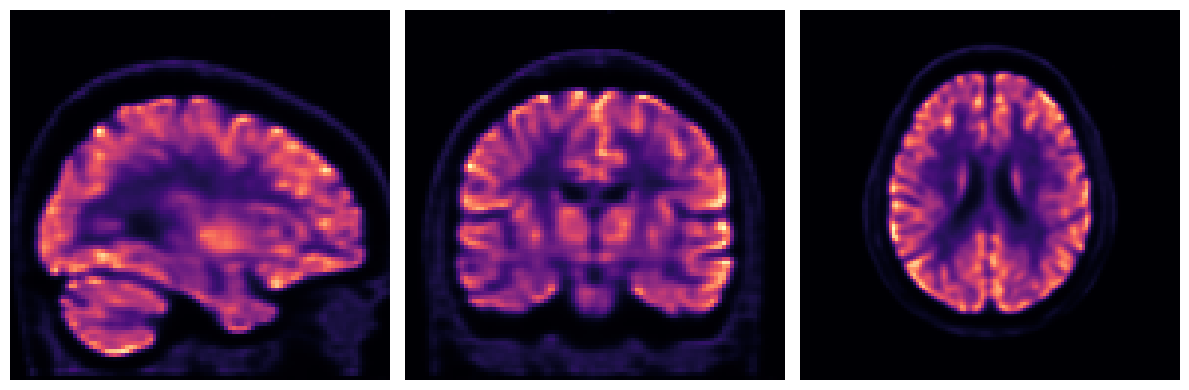

In [23]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon[0,48,16:-16].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon[0,16:-16,64].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon[0,:,:,48].cpu().T, cmap='magma')
plt.axis('off')
fig.tight_layout()
plt.show()

The data can be saved to nifit for external viewing in alternative software:

In [25]:
affine=np.eye(4); affine[-1,-1] = 0
recon_nib = nib.Nifti1Image(recon[0].cpu().numpy(), affine=affine)
nib.save(recon_nib, os.path.join(path, 'petgate_example_recon.nii.gz'))